# Topic modelling for Dreamachine dataset

Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 16/09/2025\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



### imports and global setup

In [1]:
# %%capture

import torch
import os
import numpy as np
import nltk
import sys
import pandas as pd
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP
import datamapplot
import random
from sklearn.metrics.pairwise import cosine_similarity
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration
import matplotlib.pyplot as plt



# Global random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): #will be false on mac but true with gpus
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Environment setup
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

# Add project root to path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

# Import project modules
from src.preprocessor import split_sentences
from src.utils import get_params_grid, calculate_coherence,calculate_embedding_coherence
from src.model import setup_model, setup_umap, setup_hdbscan
from configs.dreamachine2 import config
from src.llama_CPP_custom import *

dataset = "DREAMACHINE"
condition = "DL"

print(f"Current working directory: {os.getcwd()}")
BOX_DIR = os.path.join(os.path.expanduser("~"), "Library", "CloudStorage", "Box-Box", "TMDATA")
print(f"Retrieving data from BOX, locally stored at: {BOX_DIR}")
DATA_DIR = os.path.join(BOX_DIR, dataset)
print(f"Data directory: {DATA_DIR}")
results_dir = os.path.join(project_root, "EVAL",dataset.lower())

Current working directory: /Users/rb666/Projects/MOSAIC/scripts
Retrieving data from BOX, locally stored at: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA
Data directory: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE


[nltk_data] Downloading package stopwords to /Users/rb666/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Define parameters for current run


In [2]:

sentences = True
random_seed = SEED # uses the global seed 

# # Outlier reduction settings
# reduce_outliers = False
# outlier_strategy = 'embeddings' 
# outlier_threshold = 0.7 #works well with 'embeddings' and 0.7 threshold OR 'probabilities' and 0.15 threshold


### Load and preprocess data


In [3]:

reports_path = os.path.join(DATA_DIR, f"{condition}_reflections_APIcleaned.csv")
print("Using data from:", reports_path)


# load data and divide into sentences if needed
df_reports = pd.read_csv(reports_path)['cleaned_reflection'].dropna().reset_index(drop=True)
df_reports


Using data from: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE/DL_reflections_APIcleaned.csv


0     The colours made patterns when I had my eyes c...
1     Not sure what the purpose of it was except bei...
2     This should be available for everyone all the ...
3     Detachment, as though my body was in one box, ...
4                                            A doorway.
                            ...                        
93    Strange lights and a sense of relaxation. I wa...
94    Had my eyes shut most of the time; was aware o...
95    I saw a lot of imagery and colours, especially...
96    Pleasant, but should I be seeing something une...
97    I saw past experiences and reflected on my cho...
Name: cleaned_reflection, Length: 98, dtype: object

### Pre-processing


In [4]:
#divide in sentences if needed
if sentences:
    df_reports = split_sentences(df_reports)[0]
print(f"\nSuccessfully loaded and processed {len(df_reports)} sentences.")


#remove sentences defined as too short
min_words = 2 #threshold for minimum words in a sentence
#print all sentences that contain only min_words word
for i, sentence in enumerate(df_reports):
    if len(sentence.split()) < min_words:
        print(sentence)

#print the amount of sentences that have less than min_words words
short_sentences = [sentence for sentence in df_reports if len(sentence.split()) < min_words]
print(f"\nThere are {len(short_sentences)} sentences with less than {min_words} words.\n")

# Remove sentences with less than 2 words
df_reports = [sentence for sentence in df_reports if len(sentence.split()) >= min_words]
print(f"After removing short sentences, {len(df_reports)} sentences remain.")

# Remove duplicate sentences if any
seen = set()
df_reports = [s for s in df_reports if not (s in seen or seen.add(s))]
print(f"After removing duplicates, {len(df_reports)} remain.")


Successfully loaded and processed 205 sentences.
Calm.
x
Euphoric.
Euphoric.
Bliss.
Nothing.
Blue.

There are 7 sentences with less than 2 words.

After removing short sentences, 198 sentences remain.
After removing duplicates, 198 remain.


### Setup models (sentence transformer and countvectorizer) and generate embeddings

In [5]:
# Models setup (from configs)
print("Setting up models and generating embeddings...")

embedding_model = SentenceTransformer(config.transformer_model)
print("Using embedding model:", config.transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)

vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=config.max_df,
    min_df=config.min_df
)

print("Embeddings and vectorizer ready.")

Setting up models and generating embeddings...
Using embedding model: Qwen/Qwen3-Embedding-0.6B


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Embeddings and vectorizer ready.


### Train BERTopic model 

In [6]:
### Chose either to load best params from grid search, optuna or use defaults tailored ones from the config file

param_selection = "optuna" #can be "optuna", "default", or "grid_search"
target_trial_number = None#65 #or None
sanitized_model_name = config.transformer_model.replace('/', '_') #name of the transformer model with '/' replaced by '_'


if param_selection=="optuna":
    if target_trial_number is None:
        params = pd.read_csv(os.path.join(results_dir,f"OPTUNA_results_{condition}_{'sentences' if sentences else ''}_{sanitized_model_name}.csv")).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
        chosen_params = params.iloc[0]
        print("Best parameters loaded from optuna:")
        print(chosen_params)
    else:
        params = pd.read_csv(os.path.join(results_dir,f"OPTUNA_results_{condition}_{'sentences' if sentences else ''}_{sanitized_model_name}.csv"))
        chosen_params_row = params[params['trial_number'] == target_trial_number]
        # Check if the trial was actually found in the file
        if not chosen_params_row.empty:
            # .iloc[0] selects the first row of the filtered result, which gives us the parameter series
            chosen_params = chosen_params_row.iloc[0]
            print(f"Parameters successfully loaded for Optuna trial number: {target_trial_number}")
            print(chosen_params)
        else:
            raise ValueError(f"Error: Trial number {target_trial_number} was not found in the results file.")

elif param_selection=="grid_search":
    params = pd.read_csv(os.path.join(results_dir,f"GS_results_{condition}_{'sentences' if sentences else ''}.csv")).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
    chosen_params = params.iloc[0]
    print("Best parameters loaded from grid search:")
    print(chosen_params)
elif param_selection=="default":
    print(f"Loading default parameters for condition: {condition}")
    chosen_params = config.get_default_params(condition)
    print("Default parameters loaded:")
    print(pd.Series(chosen_params))
else:
    raise ValueError("param_selection must be 'optuna', 'default', or 'grid_search'")


Best parameters loaded from optuna:
trial_number             92.000000
embedding_coherence       0.560545
n_components              7.000000
n_neighbors               8.000000
min_dist                  0.040000
min_cluster_size         10.000000
min_samples               9.000000
coherence_score           0.509148
coherence_score_umass   -17.678234
n_topics                  8.000000
Name: 0, dtype: float64


In [7]:


# --- Setup UMAP and HDBSCAN models ---
umap_model = setup_umap(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=int(chosen_params['n_components']),
    min_dist=float(chosen_params['min_dist']),
    random_seed=random_seed
)


hdbscan_model = setup_hdbscan(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
)

# Initialise and fit the main Topic model
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    # representation_model=representation_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=config.top_n_words, #how many key words are generated for each topic's default representation
    nr_topics="auto",
    verbose=True,
    calculate_probabilities=True # Needed for the 'probabilities' outlier reduction strategy
)

topics, probs = topic_model.fit_transform(df_reports, embeddings) #run main training step

2025-09-26 13:55:59,987 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-26 13:56:03,195 - BERTopic - Dimensionality - Completed ✓
2025-09-26 13:56:03,195 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-26 13:56:03,203 - BERTopic - Cluster - Completed ✓
2025-09-26 13:56:03,204 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-09-26 13:56:03,214 - BERTopic - Representation - Completed ✓
2025-09-26 13:56:03,215 - BERTopic - Topic reduction - Reducing number of topics
2025-09-26 13:56:03,217 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-26 13:56:03,224 - BERTopic - Representation - Completed ✓
2025-09-26 13:56:03,225 - BERTopic - Topic reduction - Reduced number of topics from 8 to 8


### Check topic and embedding coherence

In [8]:
# Calculate initial coherence score
initial_coherence, _ = calculate_coherence(topic_model, df_reports)
embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
print(f"Initial Word-Based Coherence Score (C_v): {initial_coherence:.4f}")
print(f"Initial Embedding Coherence Score: {embedding_coherence:.4f}") # Display the new score
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")

Number of valid topics used for coherence calculation (excludes outliers -1): 7
Initial Word-Based Coherence Score (C_v): 0.5091
Initial Embedding Coherence Score: 0.5605
Initial number of topics extracted: 8
Initial number of outlier sentences: 57


### Add representations (before LLM)

In [9]:
# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr,
}

print("\nUpdating model with KeyBERT and MMR representations...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")


Updating model with KeyBERT and MMR representations...
Update complete.


### Check topics that were generated, their preliminary representation, and check which docs (sentences) were used for representation

In [10]:
topic_model.get_topic_info() #get an overview of the topics found

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,57,-1_and_to_of_the,"[and, to, of, the, in, my, was, but, dream, it]","[dreaming, memories, mind, thoughts, my, dream...","[my, dream, back, thoughts, like, saw, things,...",[There is a moment... I feel like I was drawn ...
1,0,38,0_and_peace_of_music,"[and, peace, of, music, relaxing, relaxation, ...","[relaxing, calming, calm, relaxation, soothing...","[peace, relaxing, relaxation, relaxed, asleep,...","[Relaxed, just about to sleep when music or co..."
2,1,33,1_my_to_ho_the,"[my, to, ho, the, he, was, love, me, something...","[love, loved, deserve, feeling, we, were, this...","[my, love, something, were, experience, reflec...",[I love all of it; the feeling was amazing and...
3,2,24,2_eyes_the_colours_were,"[eyes, the, colours, were, colour, my, lights,...","[flickering, eyes, colour, lights, colours, li...","[eyes, colours, colour, lights, different, saw...",[The colours behind my closed eyes swapped to ...
4,3,13,3_music_the_was_with,"[music, the, was, with, as, on, and, la, pace,...","[music, musica, playing, galloping, soundwaves...","[music, was, journey, focus, playing, piano, p...","[Music wasn't just in the space, it was the sp..."
5,4,12,4_water_then_like_in,"[water, then, like, in, and, it, felt, the, dr...","[swam, animals, swim, drowning, imagery, water...","[water, like, drowning, animals, land, saw, oc...","[And it also felt like being inside an ocean.,..."
6,5,11,5_space_travelling_of_as,"[space, travelling, of, as, in, through, light...","[space, sky, cosmos, flying, light, visuals, a...","[space, 2001, whizz, drifting, cosmos, floatin...","[My mind is a jellyfish, suspended in space., ..."
7,6,10,6_felt_like_into_body,"[felt, like, into, body, at, points, in, the, ...","[immersed, descended, sinking, darkness, death...","[felt, body, light, throughout, seat, tunnel, ...",[Then it felt like a type of death experience ...


In [11]:
docs_info = topic_model.get_document_info(df_reports)
docs_info

,Document,Topic,Name,Representation,KeyBERT,MMR,Representative_Docs,Top_n_words,Probability,Representative_document
0,The colours made patterns when I had my eyes c...,2,2_eyes_the_colours_were,"[eyes, the, colours, were, colour, my, lights,...","[flickering, eyes, colour, lights, colours, li...","[eyes, colours, colour, lights, different, saw...",[The colours behind my closed eyes swapped to ...,eyes - the - colours - were - colour - my - li...,1.000000,False
1,Not sure what the purpose of it was except bei...,-1,-1_and_to_of_the,"[and, to, of, the, in, my, was, but, dream, it]","[dreaming, memories, mind, thoughts, my, dream...","[my, dream, back, thoughts, like, saw, things,...",[There is a moment... I feel like I was drawn ...,and - to - of - the - in - my - was - but - dr...,0.558314,False
2,"Otherwise, interesting but confusing experienc...",-1,-1_and_to_of_the,"[and, to, of, the, in, my, was, but, dream, it]","[dreaming, memories, mind, thoughts, my, dream...","[my, dream, back, thoughts, like, saw, things,...",[There is a moment... I feel like I was drawn ...,and - to - of - the - in - my - was - but - dr...,0.474559,False
3,"Don't think the lights were in sync, too, to g...",2,2_eyes_the_colours_were,"[eyes, the, colours, were, colour, my, lights,...","[flickering, eyes, colour, lights, colours, li...","[eyes, colours, colour, lights, different, saw...",[The colours behind my closed eyes swapped to ...,eyes - the - colours - were - colour - my - li...,0.478259,False
4,This should be available for everyone all the ...,0,0_and_peace_of_music,"[and, peace, of, music, relaxing, relaxation, ...","[relaxing, calming, calm, relaxation, soothing...","[peace, relaxing, relaxation, relaxed, asleep,...","[Relaxed, just about to sleep when music or co...",and - peace - of - music - relaxing - relaxati...,0.449271,False
...,...,...,...,...,...,...,...,...,...,...
193,"I saw a lot of imagery and colours, especially...",4,4_water_then_like_in,"[water, then, like, in, and, it, felt, the, dr...","[swam, animals, swim, drowning, imagery, water...","[water, like, drowning, animals, land, saw, oc...","[And it also felt like being inside an ocean.,...",water - then - like - in - and - it - felt - t...,1.000000,True
194,Also abstract forms and pink and red colours.,0,0_and_peace_of_music,"[and, peace, of, music, relaxing, relaxation, ...","[relaxing, calming, calm, relaxation, soothing...","[peace, relaxing, relaxation, relaxed, asleep,...","[Relaxed, just about to sleep when music or co...",and - peace - of - music - relaxing - relaxati...,0.219346,False
195,"Pleasant, but should I be seeing something une...",1,1_my_to_ho_the,"[my, to, ho, the, he, was, love, me, something...","[love, loved, deserve, feeling, we, were, this...","[my, love, something, were, experience, reflec...",[I love all of it; the feeling was amazing and...,my - to - ho - the - he - was - love - me - so...,0.182347,False
196,I saw past experiences and reflected on my cho...,1,1_my_to_ho_the,"[my, to, ho, the, he, was, love, me, something...","[love, loved, deserve, feeling, we, were, this...","[my, love, something, were, experience, reflec...",[I love all of it; the feeling was amazing and...,my - to - ho - the - he - was - love - me - so...,0.201567,False


In [12]:
topic_id = 1 #check this topic content

print(f"Representative sentences for topic {topic_id}: ",topic_model.get_representative_docs(topic_id)) #get representative documents for topic 1

all_sentences_topic = [doc for doc, topic in zip(df_reports, topics) if topic == topic_id] #get all sentences assigned to topic 1
print(f"\nNumber of documents assigned to topic {topic_id}: {len(all_sentences_topic)}\n")
for doc in all_sentences_topic:
    print(doc)


docs_info= topic_model.get_document_info(df_reports)
topic_docs = docs_info[docs_info['Topic'] == topic_id]
topic_docs_sorted = topic_docs.sort_values(by='Probability', ascending=False)#.reset_index(drop=True)


topic_docs_sorted = topic_docs_sorted.rename(columns={
    'Document': 'Sentence',
    'Probability': 'Topic_Probability'
})

result_table = topic_docs_sorted[['Sentence', 'Topic_Probability','Representative_document']]

print(result_table)

result_table.to_csv(f'../RESULTS/dreamachine/topics_content/topic{topic_id}.csv')

Representative sentences for topic 1:  ['I love all of it; the feeling was amazing and I would come back.', 'Ho provato compassione per me stessa e ho realizzato il mio negative self-talking.', 'Dopo ho visto una luce rosa luminosa ed ho provato un senso di amore e ho capito che I deserve love and to be loved.']

Number of documents assigned to topic 1: 33

Then an overwhelming feeling of love and connection to everyone in the room.
He told me he was Francis of Assisi.
I asked him how I was doing and about my husband.
He told me we were doing important work that was our destiny.
At some point started experimenting and trying to recall the images I liked.
It was successful 50% of the time.
It was something very familiar to the soul but not... I experienced several emotions.
Felt numb too.
I quite enjoyed the experience.
Initially, I was interested in how others were reacting around me.
Like I am part of something bigger.
Flashes of my past, seeing my lovely Mum.
My partner, Dad, my sist

### Experiment with Vectorizer Settings (without re-training)
use the `.update_topics()` function to quickly test different `CountVectorizer` settings and see how they change the keywords (without re-running the clustering)


In [13]:
# --- First, let's see the keywords from your initial model run for comparison ---
print("--- Initial Keywords (from loaded GS parameters) ---")
# Let's look at the first 4 topics as an example
num_topics = len(topic_model.get_topic_info()) - 1 
for topic_id in range(num_topics):
    # The .get_topic() method returns a list of (word, score) tuples
    keywords = [word for word, score in topic_model.get_topic(topic_id)]
    print(f"Topic {topic_id}: {keywords}")
print("\n" + "="*80 + "\n")

--- Initial Keywords (from loaded GS parameters) ---
Topic 0: ['and', 'peace', 'of', 'music', 'relaxing', 'relaxation', 'the', 'to', 'relaxed', 'at']
Topic 1: ['my', 'to', 'ho', 'the', 'he', 'was', 'love', 'me', 'something', 'it']
Topic 2: ['eyes', 'the', 'colours', 'were', 'colour', 'my', 'lights', 'that', 'closed', 'when']
Topic 3: ['music', 'the', 'was', 'with', 'as', 'on', 'and', 'la', 'pace', 'space']
Topic 4: ['water', 'then', 'like', 'in', 'and', 'it', 'felt', 'the', 'drowning', 'animals']
Topic 5: ['space', 'travelling', 'of', 'as', 'in', 'through', 'light', 'time', 'me', '2001']
Topic 6: ['felt', 'like', 'into', 'body', 'at', 'points', 'in', 'the', 'through', 'light']




### Reduce outliers

In [14]:
#print the sentences that have been considered outliers
outlier_sentences = [doc for doc, topic in zip(df_reports, topics) if topic == -1]
print(f"N={len(outlier_sentences)} outlier sentences:")
for sentence in outlier_sentences:
    print(sentence)

N=57 outlier sentences:
Not sure what the purpose of it was except being with the music; certainly not induced to sleep/dream state as bpm too high.
Otherwise, interesting but confusing experience, not much visions either.
Detachment, as though my body was in one box, mind in another, and my anxiety came from that lack of control.
Some visuals of trees, heat, sun-like experience.
At times I felt transported to a meadow full of flowers in spring, and then the sound of the bells took me to a mountaintop.
I was struggling because my mind would go back to a string of thoughts, and to get out of it I had to take a very deep breath.
The same set of thoughts occurred thrice, and I inhaled really deep to get past it.
Some thoughts about mundane everyday things like work, but mainly felt relaxed and able to float into a dreamlike place.
So many different things.
I was a little afraid at thinking of the gas chambers.
I became a white egret from a dream last week.
I flew around the room touching 

In [15]:

# Store the original topics before the loop
original_topics = topic_model.topics_

# --- Define strategies and thresholds to test ---
strategies = ['probabilities', 'embeddings']
thresholds_to_test = {
    'probabilities': np.arange(0.1, 0.51, 0.05), #explore between 0.1 and 0.50 
    'embeddings': np.arange(0.5, 0.81, 0.05)
}

results = []

# --- Iterate over each strategy and threshold ---
for strategy in strategies:
    for threshold in thresholds_to_test[strategy]:
        print(f"Testing strategy '{strategy}' with threshold {threshold:.2f}...")
        
        # NOTE: The reduce_outliers function checks the internal state of `topic_model` before running.
        # This is why the model must be reset at the end of each iteration.
        new_topics = topic_model.reduce_outliers(
            df_reports, 
            topics, # It is safe to use the original `topics` variable here
            strategy=strategy,
            probabilities=probs,
            embeddings=embeddings,
            threshold=threshold
        )
        
        # Temporarily update the model to calculate coherence with new topics
        topic_model.update_topics(df_reports, topics=new_topics)
        
        # Calculate metrics
        num_outliers = len([t for t in new_topics if t == -1])
        cv_coherence, _ = calculate_coherence(topic_model, df_reports)
        emb_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)

        # Store results
        results.append({
            'Strategy': strategy,
            'Threshold': threshold,
            'Num_Outliers': num_outliers,
            'Cv_Coherence': cv_coherence,
            'Embedding_Coherence': emb_coherence
        })
        
        # THIS IS THE CRITICAL FIX: Reset the model to its original state before the next iteration
        topic_model.update_topics(df_reports, topics=original_topics)

# --- Create and display the results DataFrame ---
results_df = pd.DataFrame(results)
print("\n--- Evaluation Complete ---")
display(results_df)

2025-09-26 13:56:08,682 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Testing strategy 'probabilities' with threshold 0.10...


2025-09-26 13:56:10,802 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:10,817 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'probabilities' with threshold 0.15...


2025-09-26 13:56:12,830 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:12,837 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'probabilities' with threshold 0.20...


2025-09-26 13:56:14,853 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:14,870 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'probabilities' with threshold 0.25...


2025-09-26 13:56:16,906 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:16,920 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'probabilities' with threshold 0.30...


2025-09-26 13:56:19,028 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:19,042 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'probabilities' with threshold 0.35...


2025-09-26 13:56:21,073 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:21,087 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'probabilities' with threshold 0.40...


2025-09-26 13:56:23,149 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:23,165 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'probabilities' with threshold 0.45...


2025-09-26 13:56:25,263 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:25,272 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'probabilities' with threshold 0.50...


2025-09-26 13:56:27,311 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:27,325 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'embeddings' with threshold 0.50...


2025-09-26 13:56:29,409 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:29,435 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'embeddings' with threshold 0.55...


2025-09-26 13:56:31,545 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:31,569 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'embeddings' with threshold 0.60...


2025-09-26 13:56:33,753 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:33,765 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'embeddings' with threshold 0.65...


2025-09-26 13:56:35,825 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:35,836 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'embeddings' with threshold 0.70...


2025-09-26 13:56:37,976 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:37,985 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'embeddings' with threshold 0.75...


2025-09-26 13:56:40,099 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-26 13:56:40,118 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7
Testing strategy 'embeddings' with threshold 0.80...


2025-09-26 13:56:42,144 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 7

--- Evaluation Complete ---


,Strategy,Threshold,Num_Outliers,Cv_Coherence,Embedding_Coherence
0,probabilities,0.10,7,0.410816,0.527229
1,probabilities,0.15,23,0.458862,0.534553
2,probabilities,0.20,41,0.423975,0.548943
3,probabilities,0.25,46,0.420445,0.552895
4,probabilities,0.30,51,0.421381,0.557171
5,probabilities,0.35,53,0.427371,0.557558
6,probabilities,0.40,55,0.421480,0.561497
7,probabilities,0.45,55,0.421480,0.561497
8,probabilities,0.50,55,0.421480,0.561497
9,embeddings,0.50,1,0.435029,0.539674


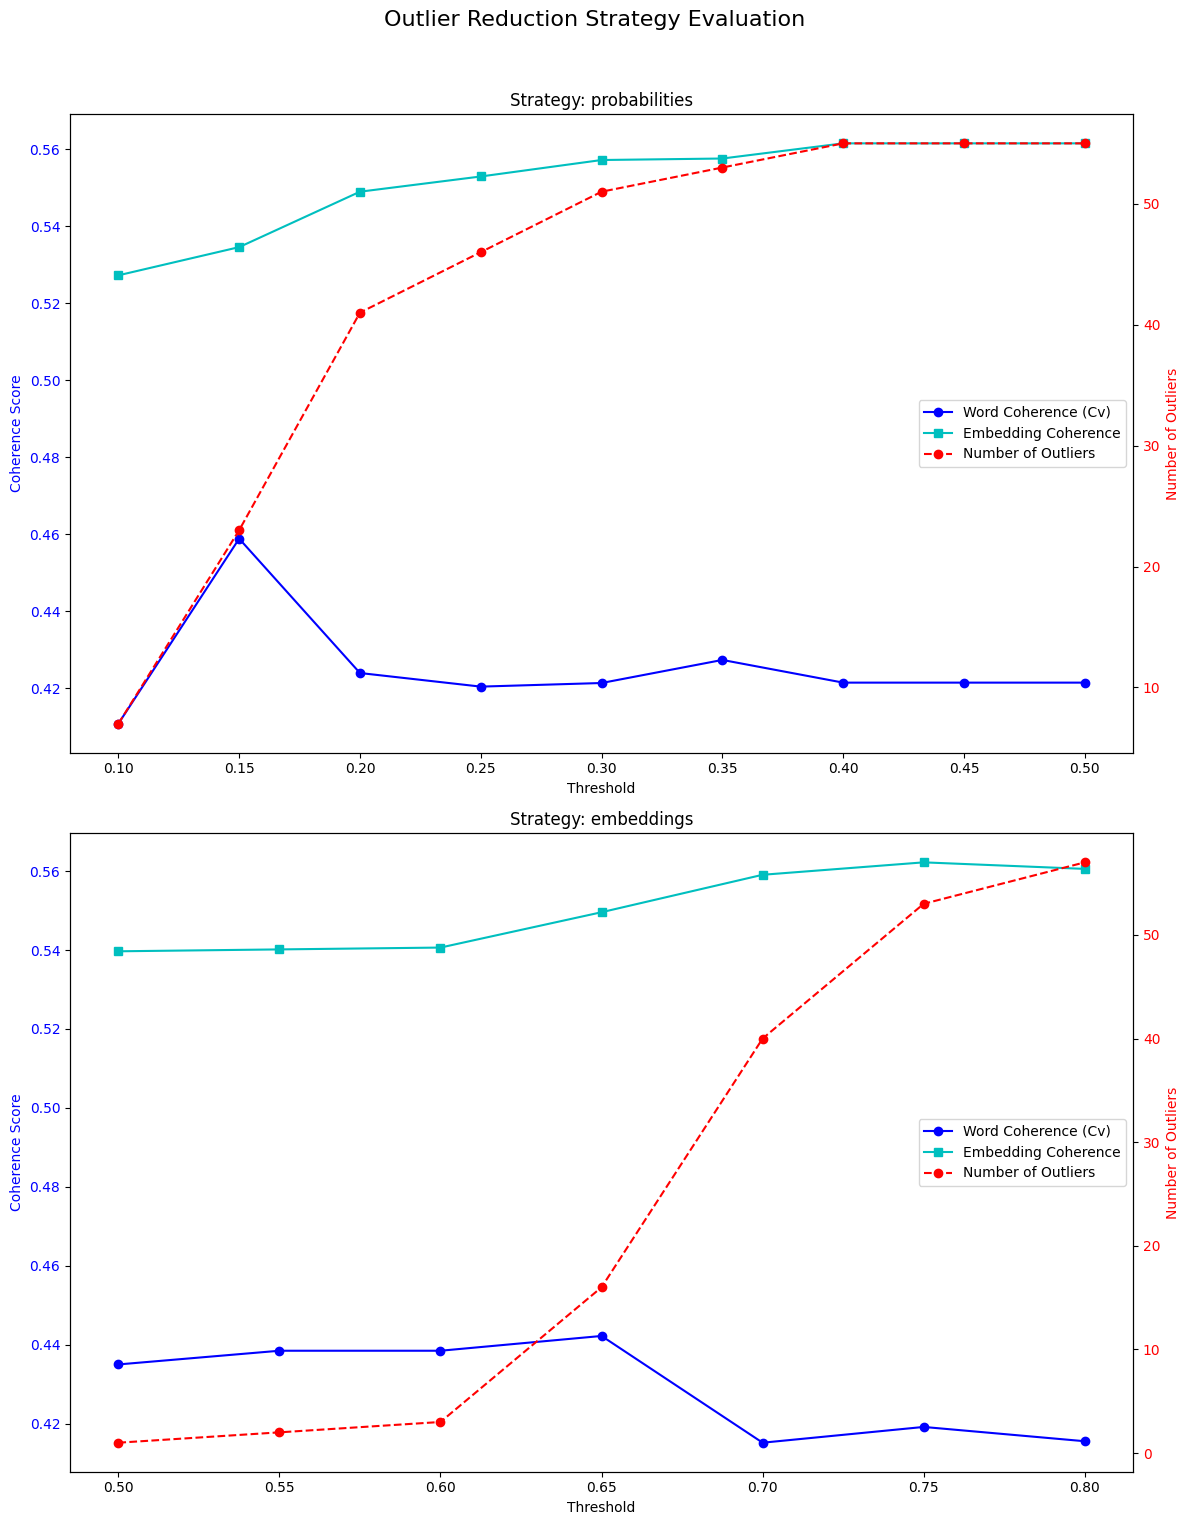

In [16]:
# --- Create plots to visualise the results ---
fig, axes = plt.subplots(len(strategies), 1, figsize=(12, 8 * len(strategies)))
fig.suptitle('Outlier Reduction Strategy Evaluation', fontsize=16)

for i, strategy in enumerate(strategies):
    ax = axes[i]
    strategy_df = results_df[results_df['Strategy'] == strategy]
    
    # Plot coherence scores on the primary y-axis
    ax.plot(strategy_df['Threshold'], strategy_df['Cv_Coherence'], 'o-', color='b', label='Word Coherence (Cv)')
    ax.plot(strategy_df['Threshold'], strategy_df['Embedding_Coherence'], 's-', color='c', label='Embedding Coherence')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Coherence Score', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax.set_title(f'Strategy: {strategy}')
    
    # Create a secondary y-axis for the number of outliers
    ax2 = ax.twinx()
    ax2.plot(strategy_df['Threshold'], strategy_df['Num_Outliers'], 'o--', color='r', label='Number of Outliers')
    ax2.set_ylabel('Number of Outliers', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [17]:
# reduce outliers (optional)
outlier_strategy = 'embeddings' 
outlier_threshold = 0.65


reduce_outliers = True

if reduce_outliers:
    print(f"\nReducing outliers using the '{outlier_strategy}' strategy with threshold {outlier_threshold}...")
    new_topics = topic_model.reduce_outliers(df_reports, topics, strategy=outlier_strategy,probabilities=probs,threshold=outlier_threshold)

    # update the topics variable for subsequent steps
    topics = new_topics
    
    # update the model with the new topic assignments
    topic_model.update_topics(df_reports, topics=topics)

    print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")
    
    # re-calculate coherence to see the impact after outlier reduction
    final_coherence, _ = calculate_coherence(topic_model, df_reports)
    print(f"Coherence Score after outlier reduction: {final_coherence}")
    embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
    print(f"Embedding Coherence Score after outlier reduction: {embedding_coherence:.4f}") # Display the new score
    print(f"Number of topics after outlier reduction: {len(np.unique(topics))}\n")


Reducing outliers using the 'embeddings' strategy with threshold 0.65...


2025-09-26 13:56:43,239 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Remaining outliers after reduction: 16
Number of valid topics used for coherence calculation (excludes outliers -1): 7
Coherence Score after outlier reduction: 0.44224251063037495
Embedding Coherence Score after outlier reduction: 0.5496
Number of topics after outlier reduction: 8



In [18]:
topic_model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [19]:
topic_model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

In [20]:
# Get the topic information DataFrame which contains all representations
topic_info_df = topic_model.get_topic_info()

print("--- Keywords from c-TF-IDF, KeyBERT and MMR Representations ---")

# Iterate over each row in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic
    if topic_id == -1:
        continue
        
    # CORRECTED: Directly access the columns, as they already contain the list of keywords
    ctfidf_keywords = row['Representation']
    keybert_keywords = row['KeyBERT']
    mmr_keywords = row['MMR']
    
    # Print the keywords for the current topic
    print(f"\nTopic {topic_id}:")
    print(f"  - c-TF-IDF: {ctfidf_keywords}")
    print(f"  - KeyBERT: {keybert_keywords}")
    print(f"  - MMR:     {mmr_keywords}")

print("\n" + "="*80 + "\n")

--- Keywords from c-TF-IDF, KeyBERT and MMR Representations ---

Topic 0:
  - c-TF-IDF: ['and', 'of', 'to', 'peace', 'relaxed', 'the', 'music', 'relaxation', 'relaxing', 'almost']
  - KeyBERT: ['relaxing', 'calming', 'calm', 'relaxation', 'soothing', 'meditation', 'retreat', 'peace', 'quietened', 'peaceful']
  - MMR:     ['peace', 'relaxing', 'relaxation', 'relaxed', 'asleep', 'lightness', 'peaceful', 'calm', 'physical', 'sounds']

Topic 1:
  - c-TF-IDF: ['to', 'my', 'the', 'ho', 'it', 'was', 'he', 'of', 'and', 'past']
  - KeyBERT: ['love', 'loved', 'deserve', 'feeling', 'we', 'were', 'this', 'see', 'compassione', 'my']
  - MMR:     ['my', 'love', 'something', 'were', 'experience', 'reflected', 'seeing', 'connection', 'told', 'feeling']

Topic 2:
  - c-TF-IDF: ['the', 'eyes', 'colours', 'were', 'colour', 'my', 'lights', 'that', 'closed', 'when']
  - KeyBERT: ['flickering', 'eyes', 'colour', 'lights', 'colours', 'light', 'hallucinations', 'vivid', 'nebulous', 'saw']
  - MMR:     ['eyes'

# Update model with LLAMA 3 for Topic Labelling

In [21]:
print("\nSetting up Llama3 for topic representation...")

# LLama setup
model_path = hf_hub_download(
    repo_id="NousResearch/Meta-Llama-3-8B-Instruct-GGUF",
    filename="Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n","Label:","Topic name:","Keywords:","(Note:","Note:","The label is:"],verbose=False)


Setting up Llama3 for topic representation...


llama_context: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64  

In [22]:

    
pipeline_kwargs = {
    "max_tokens": 15, 
    "temperature": 0.2,
    "repeat_penalty": 1.2
}

prompt = """Below are documents and keywords that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]


TASK:
Generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.

Only return the label itself, without any additional text or punctuation.


LABEL:
"""


prompt_custom = """Below are sentences and keyword sets that describe a single topic.

SENTENCES:
[SENTENCES]

KEYWORDS:
- [KEYWORDS]
- [KEYBERT_KEYWORDS]
- [MMR_KEYWORDS]

TASK:
Uses information from the SENTENCES and the KEYWORDS to generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise but precise (max 10 words).
- It must reflect directly reported phenomena.

Only return the label itself, without any additional text or punctuation.


LABEL:
"""



# Instantiate our new custom model
llm_model = LlamaCPP(llm, prompt=prompt,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3)
llm_model_custom = PhenoLabeler(llm, prompt=prompt_custom,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3,verbose=False) #set verbose to True to see which sentences and keywords have been used as LLM input
lll_model_custom2 = MultiKeywordLLM(llm, prompt=prompt_custom, pipeline_kwargs=pipeline_kwargs,nr_docs=10)

# Define the representation model using our custom class
representation_model = {"LLM": llm_model,"LLM_Custom": llm_model_custom,"LLM_Custom2": lll_model_custom2}

# UPDATE THE FITTED MODEL - this now works as you originally wanted
print("Updating topic representations with custom Llama 3 prompter...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")

#now check our new generatd labels
topic_model.get_topic_info()

Updating topic representations with custom Llama 3 prompter...


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Update complete.


,Topic,Count,Name,Representation,KeyBERT,MMR,LLM,LLM_Custom,LLM_Custom2,Representative_Docs
0,-1,16,-1_out_string_and_of,"[out, string, and, of, there, to, my, could, w...","[dreaming, memories, mind, thoughts, my, dream...","[my, dream, back, thoughts, like, saw, things,...","[Perceptual States and Consciousness, , , , , ...",[Lucid Dreaming and Altered States of Consciou...,NaN,[There is a moment... I feel like I was drawn ...
1,0,50,0_and_of_to_peace,"[and, of, to, peace, relaxed, the, music, rela...","[relaxing, calming, calm, relaxation, soothing...","[peace, relaxing, relaxation, relaxed, asleep,...",[Mindfulness and Relaxation Through Sound Expe...,[Meditative Experience of Relaxation and Inner...,Relaxation and Peaceful Music Experience\n```\...,"[Relaxed, just about to sleep when music or co..."
2,1,41,1_to_my_the_ho,"[to, my, the, ho, it, was, he, of, and, past]","[love, loved, deserve, feeling, we, were, this...","[my, love, something, were, experience, reflec...",[Spiritual Experiences of Connection and Self-...,"[Spiritual Awakening Experience, , , , , , , ,...",```\n\nThe output of this task is a single sci...,[I love all of it; the feeling was amazing and...
3,2,27,2_the_eyes_colours_were,"[the, eyes, colours, were, colour, my, lights,...","[flickering, eyes, colour, lights, colours, li...","[eyes, colours, colour, lights, different, saw...",[Phenomenology of Visual Perception in Closed ...,[Visual Hallucinations Induced by Flickering L...,Visual Hallucinations of Flickering Lights\n``...,[The colours behind my closed eyes swapped to ...
4,3,14,3_music_the_was_with,"[music, the, was, with, took, as, and, on, at,...","[music, musica, playing, galloping, soundwaves...","[music, was, journey, focus, playing, piano, p...","[The Power of Music on Spatial Perception, , ,...",[The Power of Music to Induce Imaginative Jour...,Music as a Journey Through Space and Time\n```...,"[Music wasn't just in the space, it was the sp..."
5,4,19,4_and_water_in_then,"[and, water, in, then, saw, blue, ocean, being...","[swam, animals, swim, drowning, imagery, water...","[water, like, drowning, animals, land, saw, oc...",[Imagery and Perception of Aquatic Environment...,"[Imagery of Water and Animal Encounters, , , ,...",Water and Animals Interactions\n```\n\nThis ta...,"[And it also felt like being inside an ocean.,..."
6,5,15,5_space_in_time_of,"[space, in, time, of, travelling, as, the, lik...","[space, sky, cosmos, flying, light, visuals, a...","[space, 2001, whizz, drifting, cosmos, floatin...",[Imaginary Space-Time Experiences and Phenomen...,"[Space Imagery and Perception, , , , , , , , , ]",Space Travel and Exploration\n```\n\nThe task ...,"[My mind is a jellyfish, suspended in space., ..."
7,6,16,6_felt_like_body_into,"[felt, like, body, into, was, my, in, to, and,...","[immersed, descended, sinking, darkness, death...","[felt, body, light, throughout, seat, tunnel, ...","[Out-of-Body Experience, , , , , , , , , ]","[Out-of-Body Experience, , , , , , , , , ]",Body Immersion and Sensory Experience\n```\nTh...,[Then it felt like a type of death experience ...


In [23]:
# Get the latest topic information DataFrame
topic_info_df = topic_model.get_topic_info()

print("--- Comparison of LLM vs. LLM_Custom Labels ---")

# Iterate over each topic in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic at the top of the DataFrame
    if topic_id == -1:
        continue
        
    # --- Clean the label from the standard 'LLM' column ---
    # The label is the first item in a list, so we select it.
    try:
        llm_label = row['LLM'][0].strip()
    except (TypeError, IndexError):
        llm_label = "Not available"

    # --- Clean the label from our 'LLM_Custom' column ---
    # The label is the first line of a messy string, so we split by newline and take the first part.
    try:
        llm_custom_label = row['LLM_Custom'][0].strip()#row['LLM_Custom'].split('\n')[0].strip()
    except AttributeError:
        llm_custom_label = "Not available" # Handles case where the cell is empty (NaN)


    try:
        llm_custom_label2 = row['LLM_Custom2'].split('\n')[0].strip()
    except AttributeError:
        llm_custom_label2 = "Not available" # Handles case where the cell is empty (NaN)
        
    # --- Print the clean, side-by-side comparison ---
    print(f"\nTopic {topic_id}:")
    print(f"  - {'LLM:'.ljust(15)} {llm_label}")
    print(f"  - {'LLM_Custom:'.ljust(15)} {llm_custom_label}")
    print(f"  - {'LLM_Custom2:'.ljust(15)} {llm_custom_label2}")

print("\n" + "="*80 + "\n")

--- Comparison of LLM vs. LLM_Custom Labels ---

Topic 0:
  - LLM:            Mindfulness and Relaxation Through Sound Experience
  - LLM_Custom:     Meditative Experience of Relaxation and Inner Peace
  - LLM_Custom2:    Relaxation and Peaceful Music Experience

Topic 1:
  - LLM:            Spiritual Experiences of Connection and Self-Discovery
  - LLM_Custom:     Spiritual Awakening Experience
  - LLM_Custom2:    ```

Topic 2:
  - LLM:            Phenomenology of Visual Perception in Closed Eyes
  - LLM_Custom:     Visual Hallucinations Induced by Flickering Lights
  - LLM_Custom2:    Visual Hallucinations of Flickering Lights

Topic 3:
  - LLM:            The Power of Music on Spatial Perception
  - LLM_Custom:     The Power of Music to Induce Imaginative Journey
  - LLM_Custom2:    Music as a Journey Through Space and Time

Topic 4:
  - LLM:            Imagery and Perception of Aquatic Environments
  - LLM_Custom:     Imagery of Water and Animal Encounters
  - LLM_Custom2:    Water

### Process and apply topic labels generated by Llama3


In [24]:
llm_labels_raw = [label[0][0] for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [re.sub(r'\s+', ' ', label.split("\n")[0].replace('"', '')).strip() for label in llm_labels_raw]
#llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [label if label else "Unlabelled" for label in llm_labels]

all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics] #create mapping for all sentences
len(all_labels) #should be the same as the sentences

#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

print("\nGenerated Topic Labels:")
topic_labels



Generated Topic Labels:


{0: 'Mindfulness and Relaxation Through Sound Experience',
 1: 'Spiritual Experiences of Connection and Self-Discovery',
 2: 'Phenomenology of Visual Perception in Closed Eyes',
 3: 'The Power of Music on Spatial Perception',
 4: 'Imagery and Perception of Aquatic Environments',
 5: 'Imaginary Space-Time Experiences and Phenomenological States',
 6: 'Out-of-Body Experience'}

### Visualisation

Calculating medoids: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


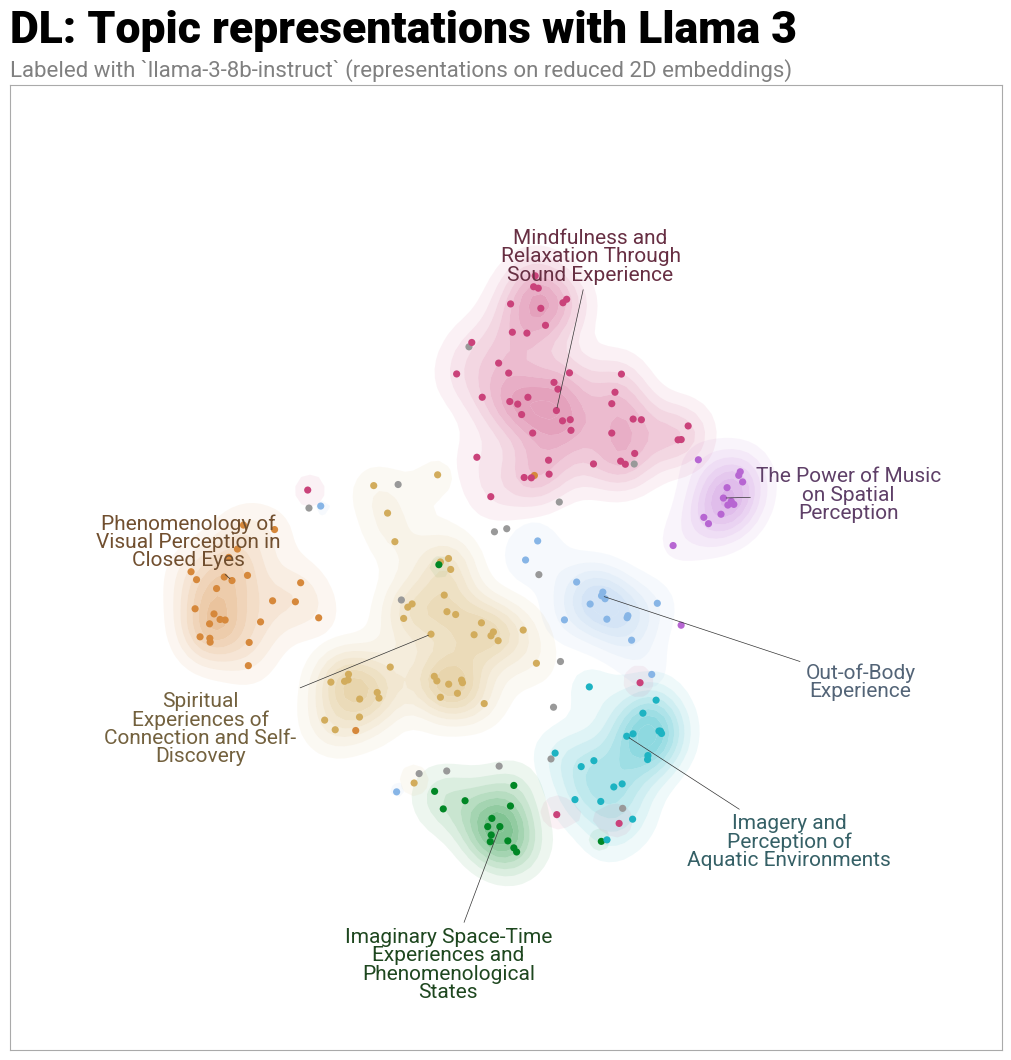

In [25]:
# Basic visu (to compare with visu before LLM labelling)
display(topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True))


# Datammaplot visu 
reduced_embeddings = UMAP(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=2, #reduced embedding to 2D for visualization
    min_dist=float(chosen_params['min_dist']),
    metric='cosine',
    random_state=random_seed
).fit_transform(embeddings)

datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition}: Topic representations with Llama 3",
   sub_title="Labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
)

# hierarchical visu
display(topic_model.visualize_hierarchy(custom_labels=True))

### create and save final topic summary

In [26]:
def create_topic_summary(topic_labels, df_reports, topics):
    """Creates df summarizing topic counts and content."""
    topic_analysis = pd.DataFrame({
        'Topic_Content': df_reports,
        'Topic_Number': topics
    })
    
    # map the topic number to the generated Llama label
    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels).fillna("Outlier")

    # Group and aggregate results
    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg(
            Sentence_Count=('Topic_Content', 'count'),
            Content=('Topic_Content', list)
        )
        .sort_values('Sentence_Count', ascending=False)
        .reset_index()
    )
    
    return topic_summary

# --- Generate and display the summary ---
topic_summary = create_topic_summary(topic_labels, df_reports, topics)

print("\nFinal Topic Summary:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

# --- Save summary to CSV ---
summary_results_file = os.path.join(project_root, "RESULTS", f"topic_analysis_{condition}.csv")
topic_summary.to_csv(summary_results_file, index=False)
print(f"\nSummary saved to {summary_results_file}")



Final Topic Summary:
                                         Topic_Label  Topic_Number  \
0  Mindfulness and Relaxation Through Sound Exper...             0   
1  Spiritual Experiences of Connection and Self-D...             1   
2  Phenomenology of Visual Perception in Closed Eyes             2   
3     Imagery and Perception of Aquatic Environments             4   
4                             Out-of-Body Experience             6   
5                                            Outlier            -1   
6  Imaginary Space-Time Experiences and Phenomeno...             5   
7           The Power of Music on Spatial Perception             3   

   Sentence_Count  
0              50  
1              41  
2              27  
3              19  
4              16  
5              16  
6              15  
7              14  

Summary saved to /Users/rb666/Projects/MOSAIC/RESULTS/topic_analysis_DL.csv
